# Gaussian Mixture Model (NIR beers dataset)

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


## Import local utility functions and classes

In [2]:
import sys
sys.path.append('../utils')
import utils as utl
from data import Data

## Model configuration

In [3]:
# model mode
model_mode      = 'training'
#model_mode      = 'predict'

# data filenames
data_filename   = '../../data/beers/NIR_beers.csv'
trace_filename  = './traces/trace_beers_nir_linear'

## Load dataset, import and plot samples

In [4]:
# init dataset object
data_obj = Data(data_filename, 'label', -1)   
data_obj.data.head(5)
data = data_obj.data
data.head(5)

,1,2,3,4,5,6,7,8,9,10,...,692,693,694,695,696,697,698,699,700,label
37,-0.002702,-0.002589,-0.002469,-0.002357,-0.002263,-0.002178,-0.002092,-0.002007,-0.001918,-0.001821,...,0.681876,0.687409,0.692493,0.697092,0.701362,0.705330,0.708713,0.711816,0.714572,2
24,0.082634,0.082764,0.082909,0.083050,0.083181,0.083316,0.083467,0.083618,0.083743,0.083857,...,0.775477,0.781133,0.786250,0.791007,0.795365,0.799252,0.802854,0.806068,0.808856,1
25,0.082543,0.082673,0.082815,0.082957,0.083087,0.083224,0.083383,0.083539,0.083664,0.083778,...,0.776522,0.782052,0.787064,0.791726,0.796006,0.799876,0.803458,0.806597,0.809245,1
36,0.084691,0.084817,0.084956,0.085100,0.085233,0.085357,0.085497,0.085652,0.085798,0.085930,...,0.767531,0.772918,0.777904,0.782356,0.786504,0.790316,0.793723,0.796759,0.799428,1
34,-0.003401,-0.003281,-0.003153,-0.003031,-0.002922,-0.002821,-0.002724,-0.002629,-0.002529,-0.002418,...,0.680850,0.686305,0.691412,0.696080,0.700388,0.704347,0.707879,0.710993,0.713759,1


1: blue
2: red


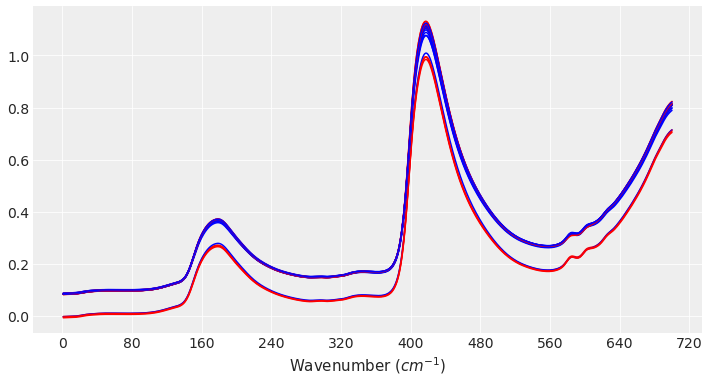

In [5]:
# list of class labels
class_labels = data_obj.get_class_labels()

# number of classes
nclasses = len(class_labels)

# plot dataframe
utl.plot_data(data_obj, 20)

In [6]:
# number of samples from each class
print(data_obj.data[data_obj.label_column].value_counts())

1    28
2    16
Name: label, dtype: int64


In [7]:
# generate training and test sets
train_data, test_data = train_test_split(data_obj.data, train_size=0.5, random_state=42)

# rename the index
test_data.index = range(len(test_data))
train_data.index = range(len(train_data))

In [8]:
test_data.shape

(22, 701)

In [9]:
train_data.shape

(22, 701)

# Model definition
The following model is assumed:

\begin{equation}
\large A_{m} \sim \text{U} (0, max(Y)) \\
\large \mu_{m} \sim \mathcal{N}(\mu_{m}, 50) \\
\large \sigma_{m} \sim |\mathcal{N}(0, 100)| \\
\large \epsilon \sim |\mathcal{N}(0, 1)| \\
\large \theta = \sum\limits_{m=1}^M [A_m \cdot e^{-\frac{(x_n-\mu_m)^2}{2\cdot\sigma_m^2}}] + a_0 + a_1 \cdot x_n \\
\large y \sim \mathcal{N}(\theta, \epsilon)
\end{equation}

In [10]:
# store the data for the classes in a list of dataframes
df = [train_data.query("label ==  @class_labels[@i]") for i in range(len(class_labels))]

# 1D array of X values
len_x = len(train_data.columns[:data_obj.non_data_columns])
x_val = np.array(train_data.columns[:data_obj.non_data_columns], dtype='float32').reshape(len_x,1)

# 2D array containing Y values (observation data)
x_n = train_data.columns[:data_obj.non_data_columns]
x_s = [df[i][x_n].values for i in range(len(df))]

In [11]:
peaks = [3]
traces = []
models = []

for npeaks in peaks:
    if model_mode == 'training':
        print("training on " + str(npeaks) + " peaks")
    
    with pm.Model() as model:
        amp = pm.Uniform('amp', 0, x_s[0].max(), shape=(nclasses,npeaks))
        mu = pm.Normal('mu', mu=np.linspace(x_val.min(), x_val.max(), npeaks), sd=50, 
                       shape=(nclasses,npeaks), transform=pm.distributions.transforms.ordered)
        sigma = pm.HalfNormal('sigma', sd=100, shape=(nclasses,npeaks))
        
        a_0 = pm.Normal('a_0', mu=0, sd=1, shape=(nclasses,1))
        a_1 = pm.Normal('a_1', mu=0, sd=1, shape=(nclasses,1))
        
        epsilon = pm.HalfNormal('epsilon', sd=1)
    
        y_a = pm.Deterministic('y_a', (amp[0] * np.exp(-(x_val - mu[0])**2/(2 * sigma[0]**2)) 
                                    + a_1[0]*x_val + a_0[0]).sum(axis=1))
        y_b = pm.Deterministic('y_b', (amp[1] * np.exp(-(x_val - mu[1])**2/(2 * sigma[1]**2))
                                    + a_1[1]*x_val + a_0[1]).sum(axis=1))
        
        y_pred_a = pm.Normal('y_pred_a', mu=y_a, sd=epsilon, observed=x_s[0])
        y_pred_b = pm.Normal('y_pred_b', mu=y_b, sd=epsilon, observed=x_s[1])
        
        if model_mode == 'training':
            #trace = pm.sample(2000, init='adapt_diag', tune=1000, random_seed=42)
            trace = pm.sample(2000, init='adapt_diag', tune=1000)
            traces.append(trace)
            models.append(model)
        else:
            # load traces from trained model
            trace = pm.backends.text.load(trace_filename)
            traces.append(trace)
            models.append(model)
            break

training on 3 peaks


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [epsilon, a_1, a_0, sigma, mu, amp]
Sampling 2 chains, 0 divergences: 100%|██████████| 6000/6000 [07:23<00:00, 13.52draws/s]
The acceptance probability does not match the target. It is 0.9328898995788213, but should be close to 0.8. Try to increase the number of tuning steps.


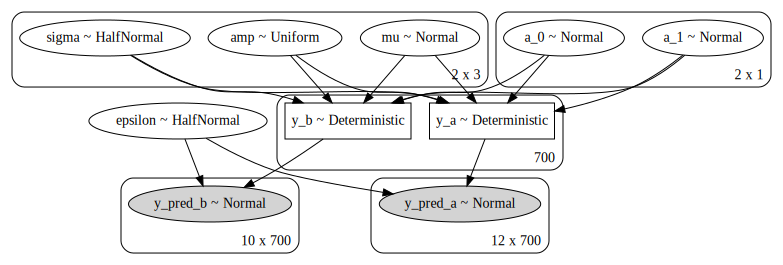

In [12]:
pm.model_to_graphviz(model)

# Model evaluation

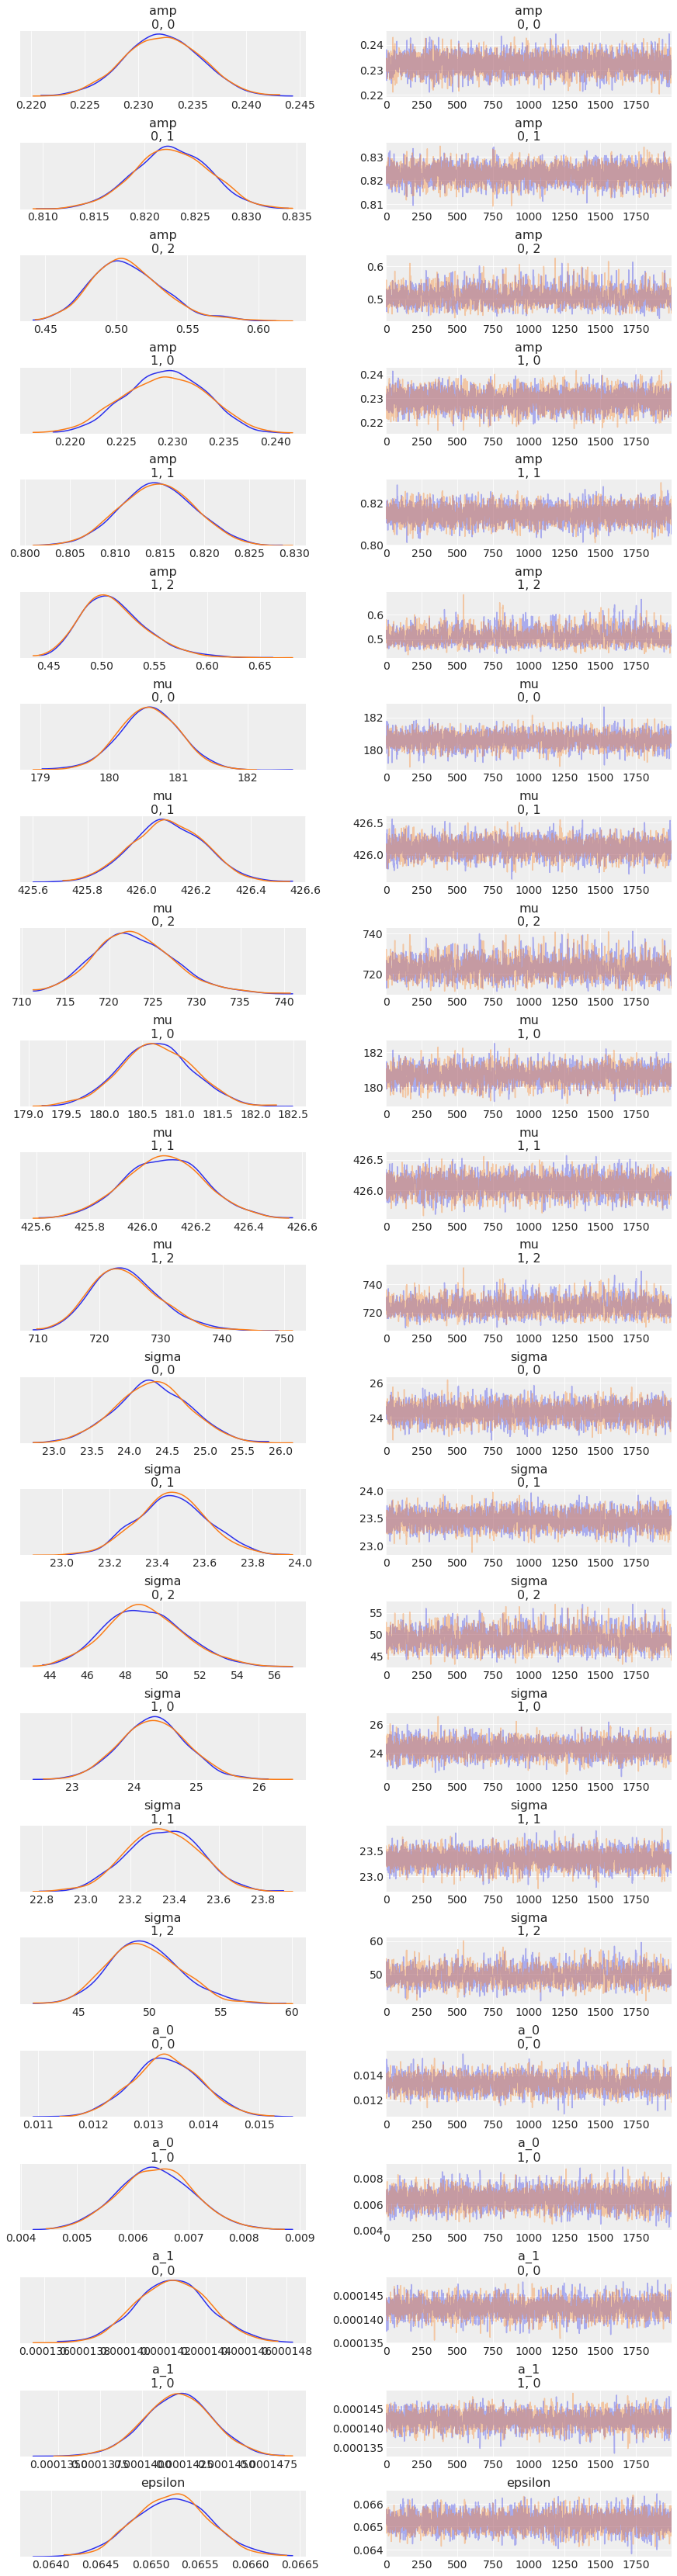

In [13]:
varnames = ['amp', 'mu', 'sigma', 'a_0', 'a_1', 'epsilon']
az.plot_trace(traces[0], varnames);

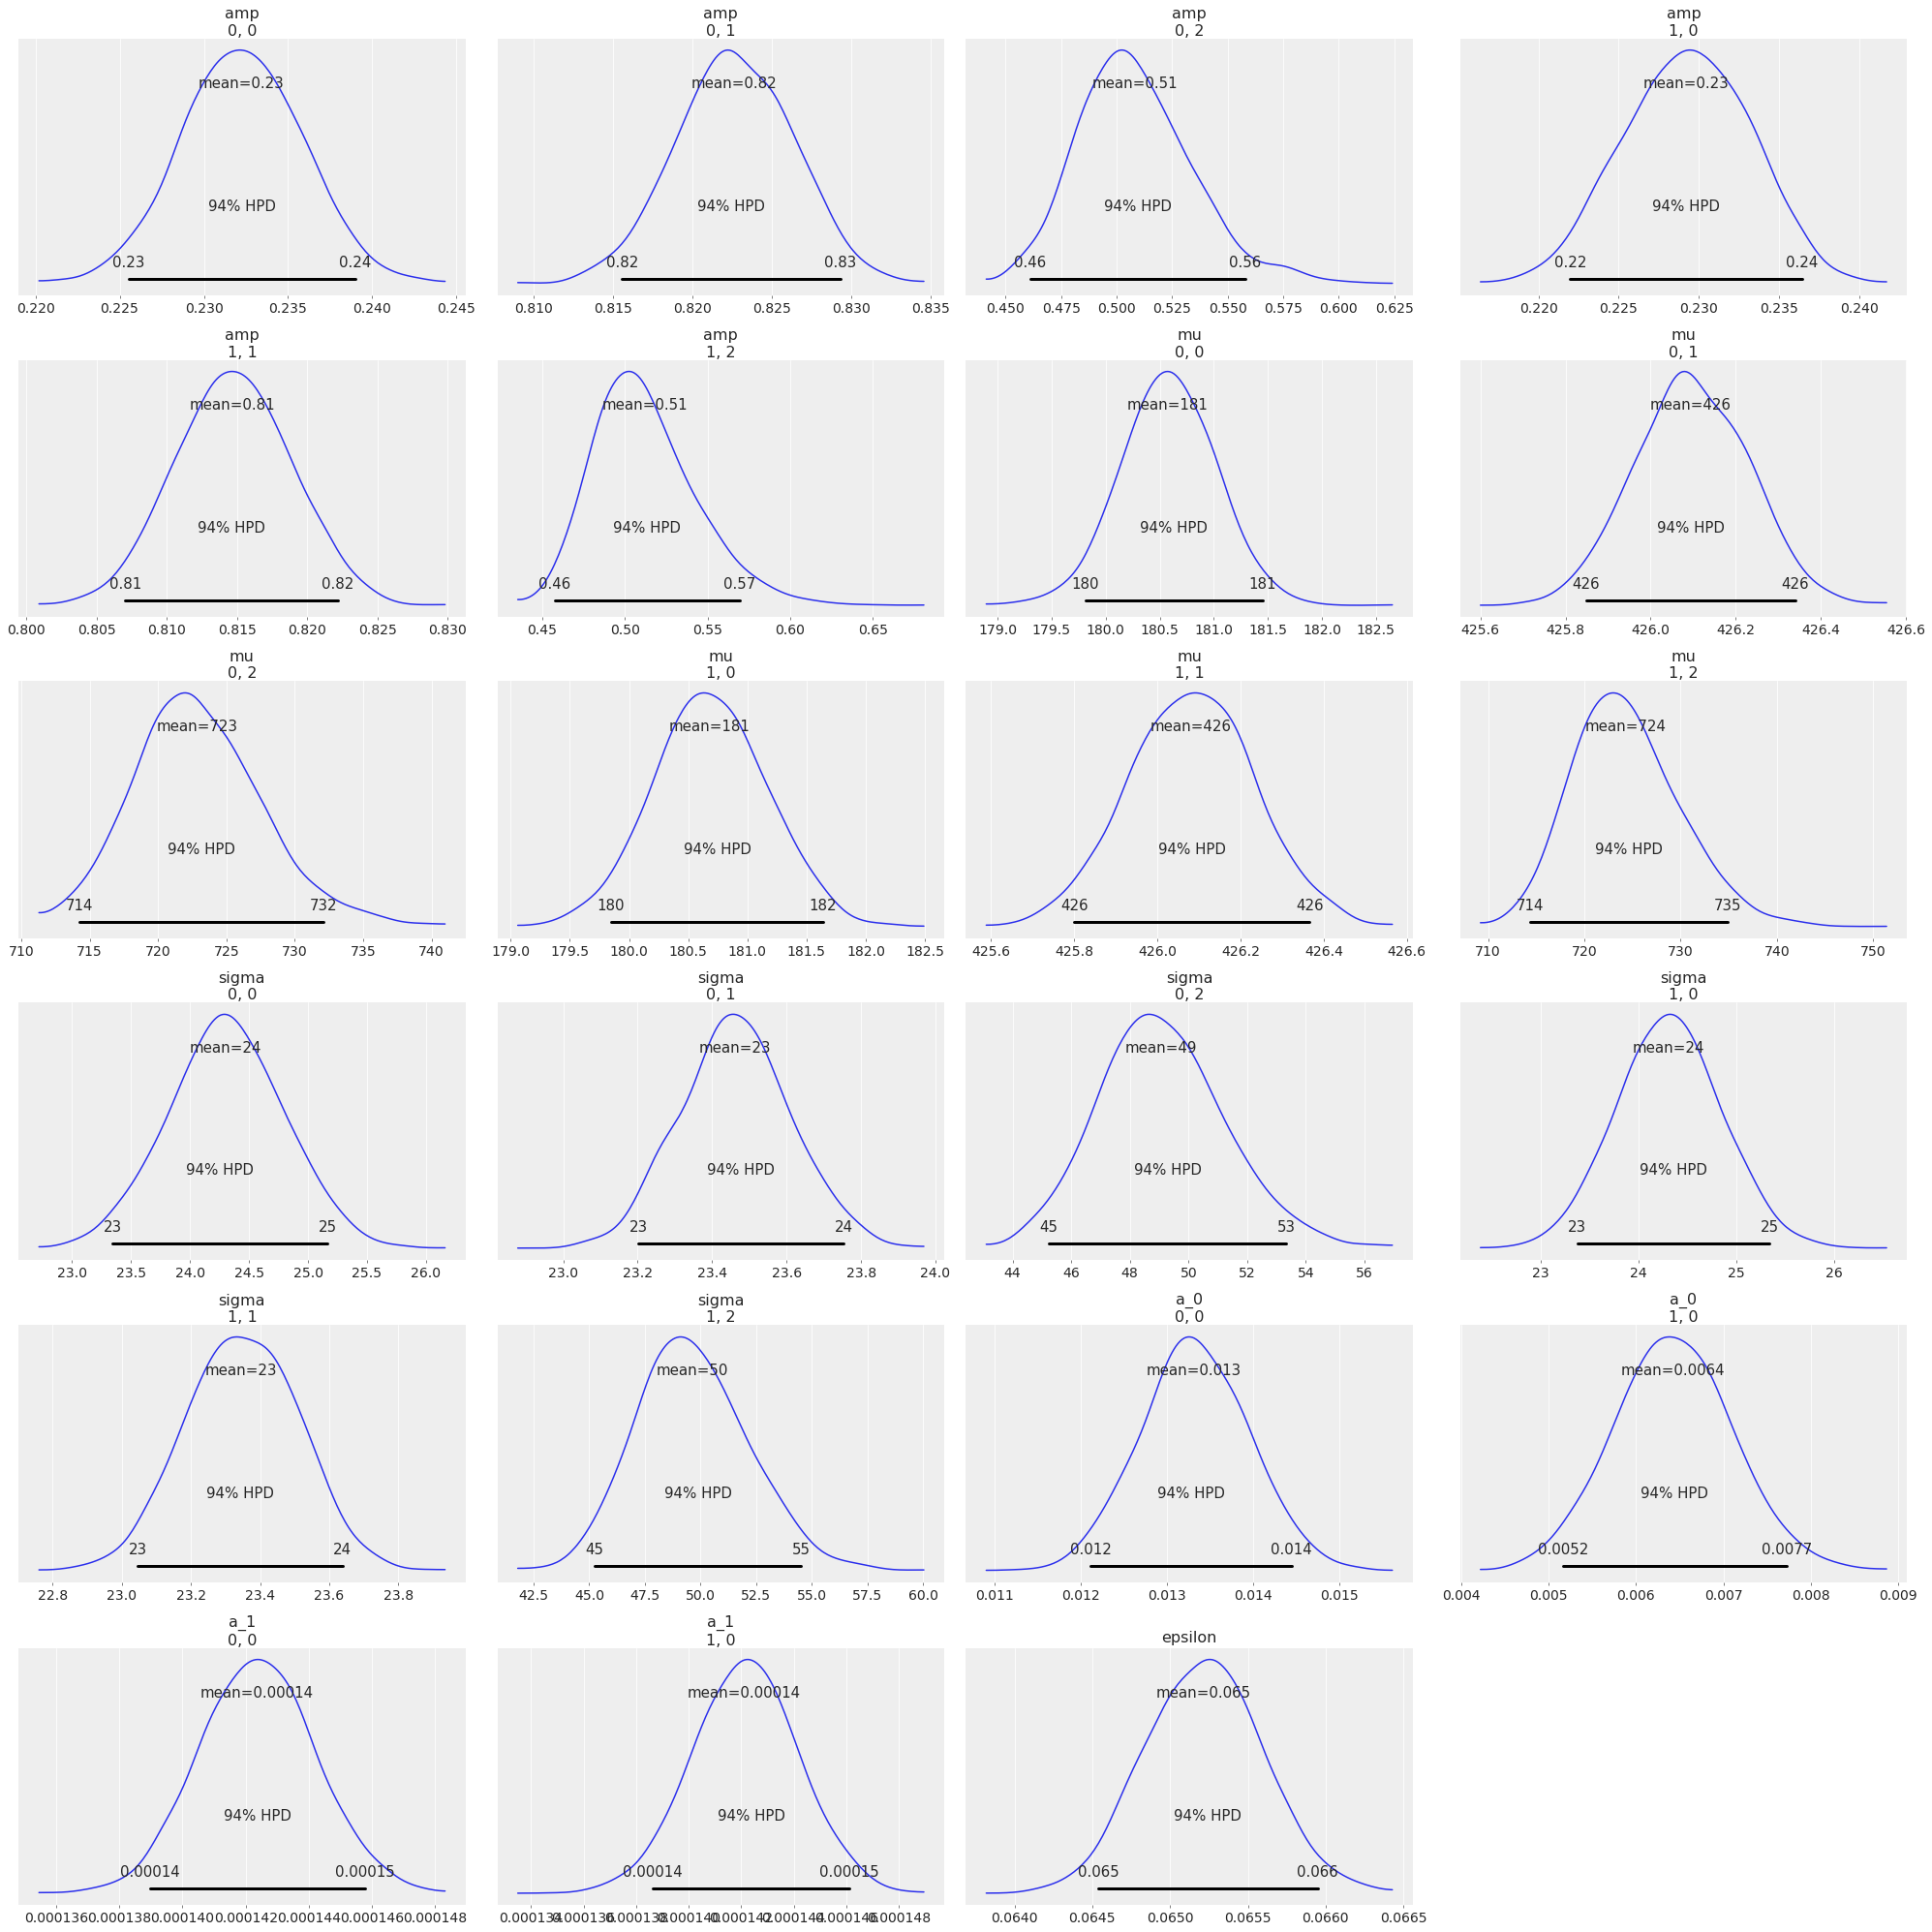

In [14]:
az.plot_posterior(traces[0], varnames);

In [15]:
ppc_mm = [pm.sample_posterior_predictive(traces[i], samples=500, model=models[i]) for i in range(len(peaks))]

/home/johan/VirtualEnv/ppsda/lib/python3.6/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 500/500 [00:03<00:00, 159.18it/s]


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


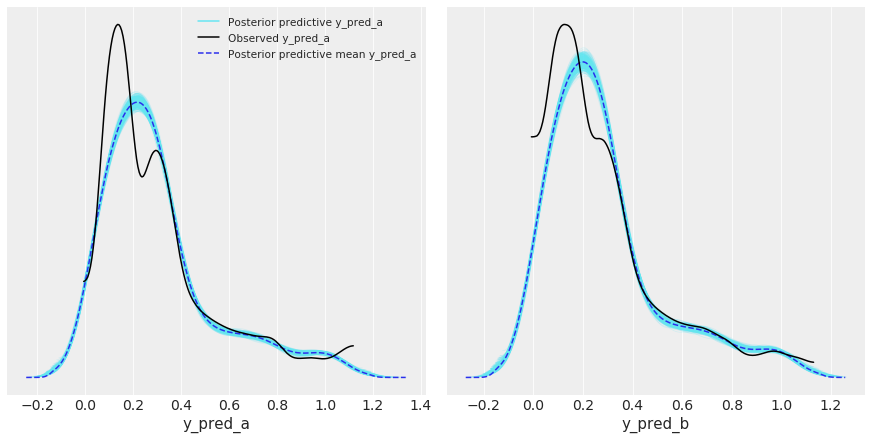

In [16]:
data_ppc = az.from_pymc3(trace=traces[0], posterior_predictive=ppc_mm[0])
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

## Compare distribution of data and posterior samples

In [17]:
x_val = x_val.reshape(len(x_val),)

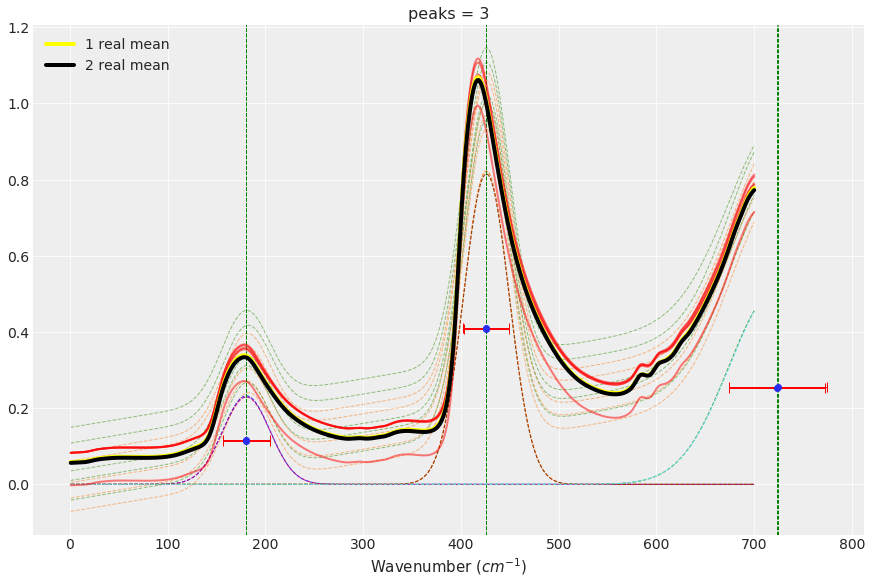

In [18]:
_, ax = plt.subplots(1, 1, figsize=(12, 8), constrained_layout=True)
ax = np.ravel(ax)
for idx, ppc_x in enumerate(ppc_mm):
    # plot samples from the posterior
    #sp = ppc_x['y_pred_a']
    #for i in range(1):
    #    ax[idx].plot(x_val, sp[i,0,:], 'o', color="black", alpha=.2)
    
    #sp = ppc_x['y_pred_b']
    #for i in range(1):
    #    ax[idx].plot(x_val, sp[i,0,:], 'o', color="red", alpha=.2)
    
    # plot 94% HPD interval
    #az.plot_hpd(x_val, ppc_x['y_pred_a'], smooth=False, credible_interval=0.98, color='lightpink')
    #az.plot_hpd(x_val, ppc_x['y_pred_b'], smooth=False, credible_interval=0.98, color='lightpink')
    
    # plot samples from the posterior model formula
    for i in range(5):
        ax[idx].plot(x_val, traces[idx]['y_a'][i] + traces[idx]['epsilon'][i]*np.random.randn(), '--',
                     color='C1', alpha=.5, linewidth=1)
        ax[idx].plot(x_val, traces[idx]['y_b'][i] + traces[idx]['epsilon'][i]*np.random.randn(), '--',
                     color='C2', alpha=.5, linewidth=1)
    
    # plot mixture components 
    A = traces[idx]['amp'].mean(axis=0).flatten()
    M = traces[idx]['mu'].mean(axis=0).flatten()
    S = traces[idx]['sigma'].mean(axis=0).flatten()
    for j in range(len(A)):
        Y = A[j] * np.exp(-(x_val - M[j])**2/(2 * S[j]**2))
        ax[idx].plot(x_val, Y, '--', linewidth=1)
        ax[idx].axvline(M[j], linestyle='--', linewidth=1, color='g')
        ax[idx].errorbar(x=M[j], y=.5*A[j], xerr=S[j], fmt='o', 
                         ecolor='r', elinewidth=1, capsize=5, capthick=1)
        
    # plot samples from the dataset
    for i in range(5):
        y_val = train_data.values[i]
        ax[idx].plot(x_val, y_val[:data_obj.non_data_columns], '-', color="red", alpha=.5, linewidth=2)
    
    # plot the mean of the real data
    class_labels = data_obj.get_class_labels()
    df = [ data_obj.data.loc[data_obj.data[data_obj.label_column] == class_labels[k]]
           for k in range(len(class_labels)) ]
    for z in range(len(df)):
        cls_label = str(class_labels[z]) + " real mean"
        ax[idx].plot(x_val, df[z].iloc[:,:data_obj.non_data_columns].mean(), '-', color=utl.get_color_mean(z),
             label=cls_label, linewidth=4)
        
    ax[idx].set(xlabel='Wavenumber ($cm^{-1}$)')
    ax[idx].set_title('peaks = {}'.format(peaks[idx]))
    ax[idx].legend(loc='best')

In [19]:
if len(models)>1:
    comp = az.compare(dict(zip(peaks, traces)), method='BB-pseudo-BMA')
    print(comp)

In [20]:
if len(models)>1:
    az.plot_compare(comp);

In [21]:
if len(models)>1:
    for idx, trace in enumerate(traces):
        print(str(peaks[idx]) + " peaks, bfmi: " + str(az.bfmi(trace)))

In [22]:
for idx, ppc in enumerate(ppc_mm):
    print("--- " + str(peaks[idx]) + " peaks -----------\n" + str(az.r2_score(x_s[0], ppc['y_pred_a'])))
    print("--- " + str(peaks[idx]) + " peaks -----------\n" + str(az.r2_score(x_s[1], ppc['y_pred_b'])))

--- 3 peaks -----------
r2        0.927793
r2_std    0.004297
dtype: float64
--- 3 peaks -----------
r2        0.926714
r2_std    0.004236
dtype: float64


In [23]:
varnames = ['amp', 'mu', 'sigma', 'a_0', 'a_1', 'epsilon']
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
    coef = az.summary(trace, varnames)
    print(coef)


--- 3 peaks ----------------------------------
               mean     sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  \
amp[0,0]      0.232  0.004    0.226    0.239      0.000    0.000    5643.0   
amp[0,1]      0.823  0.004    0.816    0.829      0.000    0.000    5421.0   
amp[0,2]      0.508  0.026    0.461    0.558      0.001    0.000    2035.0   
amp[1,0]      0.229  0.004    0.222    0.236      0.000    0.000    5704.0   
amp[1,1]      0.815  0.004    0.807    0.822      0.000    0.000    5339.0   
amp[1,2]      0.512  0.031    0.458    0.570      0.001    0.001    1583.0   
mu[0,0]     180.573  0.437  179.814  181.451      0.007    0.005    3884.0   
mu[0,1]     426.094  0.133  425.849  426.340      0.002    0.001    4077.0   
mu[0,2]     722.894  4.716  714.258  732.065      0.104    0.073    2063.0   
mu[1,0]     180.678  0.479  179.849  181.641      0.008    0.005    3867.0   
mu[1,1]     426.080  0.150  425.800  426.366      0.002    0.002    4255.0   
mu[1,2]     724.


--- 3 peaks ----------------------------------


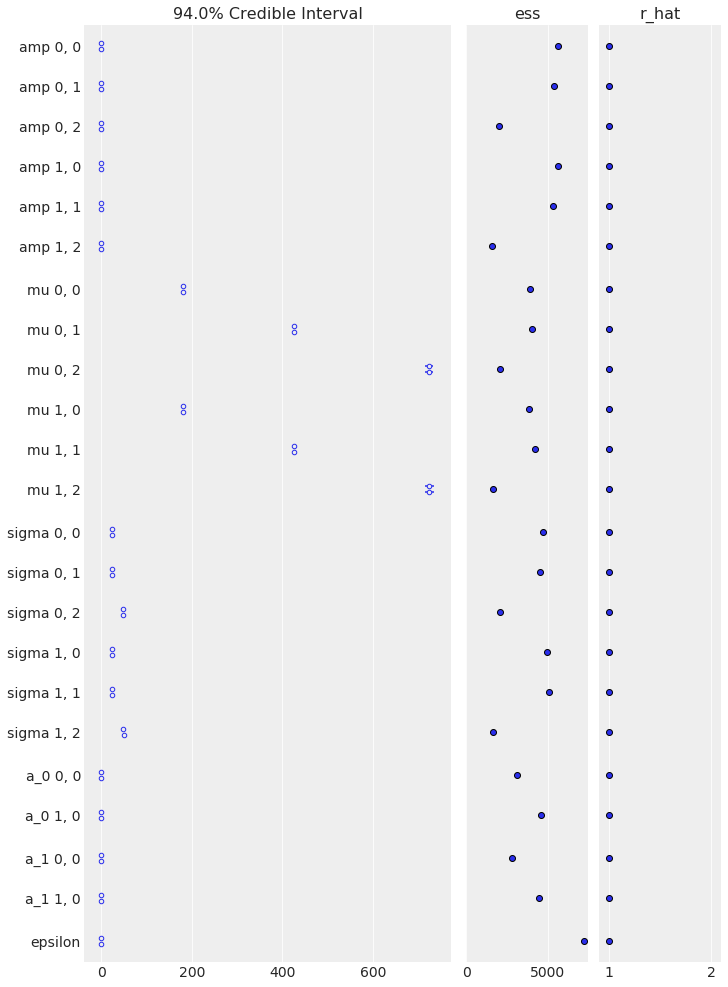

In [24]:
for idx, trace in enumerate(traces):
    print("\n--- " + str(peaks[idx]) + " peaks ----------------------------------")
    az.plot_forest(trace, var_names = varnames, r_hat=True, ess=True);

## Save results

In [25]:
if model_mode == 'training':
    # save inference results
    pm.backends.text.dump(trace_filename, traces[0])